# Credit Card Fraud Detection

Coded by Emile Badran in April/2018

This notebook aims to identify fraudulent credit card transactions. Correctly finding fraud was prioritized rather than correctly labeling non-fraudulent transactions.

**Acknowledgments**

The dataset used in this notebook was collected and analysed for a research on big data mining and fraud detection by the Machine Learning Group of the Université Libre de Bruxelles (http://mlg.ulb.ac.be). The data can be downloaded from https://www.kaggle.com/mlg-ulb/creditcardfraud/data

Authors of the original paper are: Andrea Dal Pozzolo, Olivier Caelen, Reid A. Johnson and Gianluca Bontempi. *Calibrating Probability with Undersampling for Unbalanced Classification.* In Symposium on Computational Intelligence and Data Mining (CIDM), IEEE, 2015

In [4]:
!pip install -U imbalanced-learn

Requirement already up-to-date: imbalanced-learn in /usr/local/envs/py3env/lib/python3.5/site-packages
Requirement already up-to-date: scikit-learn in /usr/local/envs/py3env/lib/python3.5/site-packages (from imbalanced-learn)
Requirement already up-to-date: scipy in /usr/local/envs/py3env/lib/python3.5/site-packages (from imbalanced-learn)
Requirement already up-to-date: numpy in /usr/local/envs/py3env/lib/python3.5/site-packages (from imbalanced-learn)
You are using pip version 9.0.1, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [5]:
import warnings
warnings.filterwarnings('ignore')

import time
import numpy as np
import pandas as pd
pd.options.display.max_columns = 100

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
%matplotlib inline

import multiprocessing
from imblearn.over_sampling import RandomOverSampler 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.model_selection import cross_val_score
from sklearn.utils import shuffle
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.svm import SVC
from sklearn import ensemble

%env JOBLIB_TEMP_FOLDER=/tmp

env: JOBLIB_TEMP_FOLDER=/tmp


### Importing and inspecting the data set

In [6]:
# This notebook runs on Google Cloud

# Import Google Cloud-related libraries
import google.datalab.storage as storage
from io import BytesIO

# Define the storage bucket name and data file variable
mybucket = storage.Bucket('la-data')
data_file = mybucket.object('creditcard.csv')

# Create a readable URI object with the data in binary format
uri = data_file.uri
%gcs read --object $uri --variable data

# Read the binary data as CSV into a Pandas data frame
raw_data = pd.read_csv(BytesIO(data))
raw_data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [7]:
# Inspect the number of rows and columns in the raw_data data frame
raw_data.shape

(284807, 31)

#### Column metadata:
- Time: Number of seconds elapsed between each transaction (over two days)
- V1 to V28: PCA components
- Amount: USD amount for each transaction
- Class: Whether the transaction was a fraud (1) or not-fraud (0)

The dataset contains credit card transactions made in September 2013 by European cardholders. It contains only numerical input variables which are the result of a PCA transformation. Due to confidentiality issues, features V1 to V28 are the principal components obtained from PCA.

#### Generate a distribution plot of fraud and not-fraud transaction times

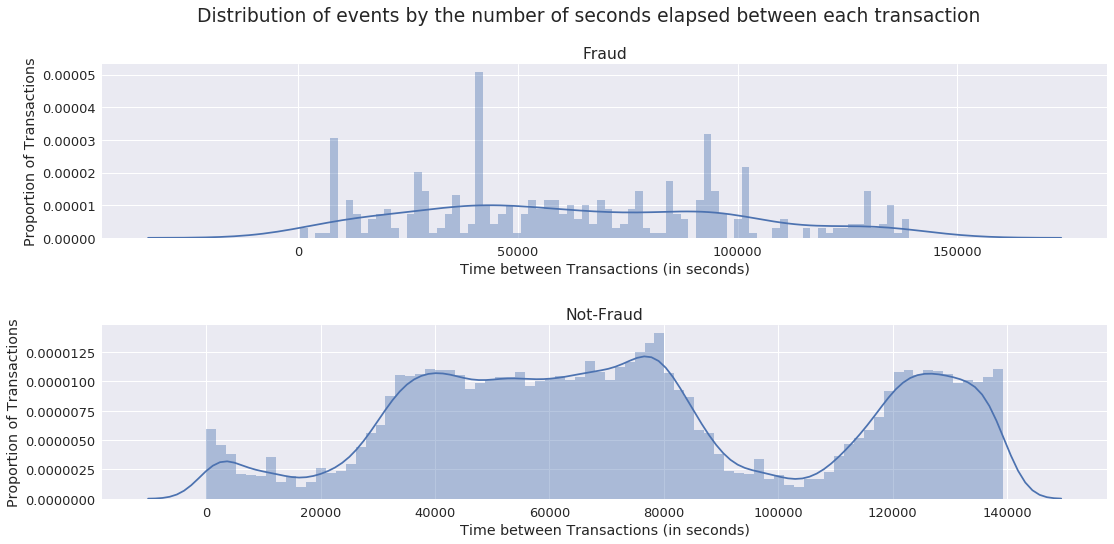

In [8]:
# Set the figure size, grid and font:
plt.figure(figsize=(18,8))
gs = gridspec.GridSpec(2, 1)
gs.update(hspace=.5)
sns.set(font_scale=1.3)

# Plot the first graph filtering outlier data:
ax1 = plt.subplot(gs[0])
ax1.set_title('Fraud')
sns.distplot(raw_data.Time[(raw_data.Class == 1)&(
    raw_data.Time < raw_data.Time.quantile(.75))], bins=80)
plt.xlabel('Time between Transactions (in seconds)')
plt.ylabel('Proportion of Transactions')

# Plot the second graph filtering outlier data:
ax2 = plt.subplot(gs[1])
ax2.set_title('Not-Fraud')
sns.distplot(raw_data.Time[(raw_data.Class == 0)&(
    raw_data.Time < raw_data.Time.quantile(.75))], bins=80)
plt.xlabel('Time between Transactions (in seconds)')
plt.ylabel('Proportion of Transactions')

# Set plot title:
plt.suptitle('Distribution of events by the number of seconds elapsed between each transaction')
plt.show()

#### Generate a distribution plot of fraud and not-fraud transaction values

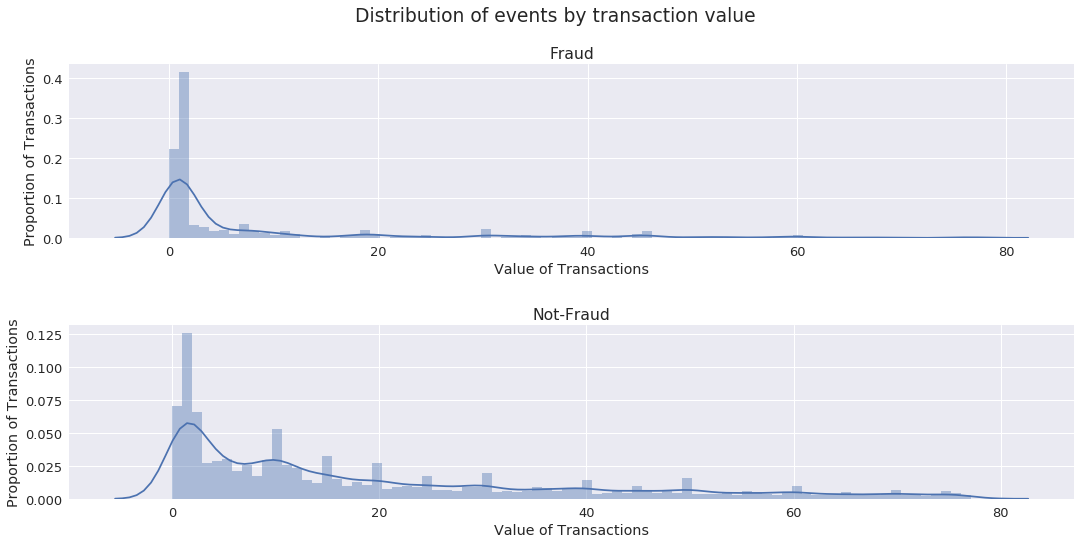

In [9]:
# Set the figure size, grid and font:
plt.figure(figsize=(18,8))
gs = gridspec.GridSpec(2, 1)
gs.update(hspace=.5)
sns.set(font_scale=1.3)

# Plot the first graph filtering outlier data:
ax1 = plt.subplot(gs[0])
ax1.set_title('Fraud')
sns.distplot(raw_data.Amount[(raw_data.Class == 1)&(
    raw_data.Amount < raw_data.Amount.quantile(.75))], bins=80)
plt.xlabel('Value of Transactions')
plt.ylabel('Proportion of Transactions')

# Plot the second graph filtering outlier data:
ax2 = plt.subplot(gs[1])
ax2.set_title('Not-Fraud')
sns.distplot(raw_data.Amount[(raw_data.Class == 0)&(
    raw_data.Amount < raw_data.Amount.quantile(.75))], bins=80)
plt.xlabel('Value of Transactions')
plt.ylabel('Proportion of Transactions')

# Set plot title:
plt.suptitle('Distribution of events by transaction value')
plt.show()

There's nothing unusual about the distributions of Fraud transactions. The timing of fraud transactions is more evenly distributed than not-fraud transactions. Fraud transactions values are mostly between 0 and 2.

### Resampling the data set to compensate class imbalance
There are 492 frauds out of 284,807 transactions. Class imbalance is 0.172%. Fraud transactions will be oversampled so the algorithm can be properly trained.

In [10]:
# Create train and test sample data frames
sample_train = shuffle(raw_data, n_samples=189543) # test sample with 2/3 of the data set 
sample_test = shuffle(raw_data, n_samples=95264) # test sample with 1/3 of the data set

# Random over sample fraud transactions for training purposes
ros = RandomOverSampler(ratio='minority')
x_train_balanced, y_train_balanced = ros.fit_sample(sample_train.iloc[:,:-1], sample_train.Class)

# The resulting balanced training sample has an equal amount of fraud/no-fraud transactions:
np.unique(y_train_balanced, return_counts=True)

(array([0, 1]), array([189200, 189200]))

### Selecting the most valuable features
Features with lower predictive potential are filtered to reduce processing time when running models and improve model stability. The score function used to select the most valuable features is ANOVA f-values.

In [11]:
# Select the 10 best features:
kbest = SelectKBest(f_classif, k=10).fit(x_train_balanced, y_train_balanced)

# Filter train and test matrices with only the k best features:
kbest_train_balanced = kbest.transform(x_train_balanced)
kbest_sample_test = kbest.transform(sample_test.iloc[:,:-1])

# Inspect sample sizes and number of dimensions
print(x_train_balanced.shape)
print(y_train_balanced.shape)
print(kbest_train_balanced.shape)
print(kbest_sample_test.shape)

(378400, 30)
(378400,)
(378400, 10)
(95264, 10)


The feature space was reduced from 30 to 10 variables.

# Predicting credit card fraud
Since this is a classification problem, the following models are used to detect credit card fraud:

- Naive Bayes
- KNN
- Random Forest
- Logistic Regression
- Support Vector Classifier
- Gradient Boosting Classifier

For each model, RandomizedSearchCV is used to randomly select and test up to 20 parameter combinations and select the most promising. The method also cross-validates each combination twice, totalling 40 fits.

RandomizedSearchCV lets you select a scoring function to choose the best parameter. Here, we're using 'recall', which returns the fold with the highest sensitivity score $ \frac{TP}{(TP+FN)} $.

The models were then run with parameters obtained from RandomizedSearchCV. The overall accurracy scores of the different models are compared in the conclusion section at the end of this notebook.

For the interest of concision, RandomizedSearchCV and parameter tuning cells were deleted from this notebook. The complete tuning procedures can be found on [this notebook file](https://github.com/ebadran/thinkfulBC/blob/master/U3/3.6.1_credit_card_fraud_TUNING.ipynb).

### Cross-validation function
This custom function was used to cross-validate all models returning confusion matrices and sensitivity scores.

In [12]:
# Define a function to cross-validate all models
def cv_models(model, folds):
    
    # Start the timer function to inspect the amount of time necessary to run the method
    start_time = time.time()
    
    # This "if" statement makes models run in the main program to prevent infinite multi-processing loops
    if __name__ == '__main__':
      multiprocessing.set_start_method('forkserver', force=True)

      # Fit the model with the selected parameters
      model.fit(kbest_train_balanced,y_train_balanced)

      # Cross-validate the model 
      print('\nCross-Validation:')

      # Split the data set to the number of folds
      step = int(len(sample_test)/folds)

      # A "for loop" calls the predict function with a sub-sample 1/5th of the size of the test data set
      start = 0
      sensitivity = []
      for i in range(folds):
        stop = start+step

        # Call the predict function for every sub-sample
        model_predicted = model.predict(kbest_sample_test[start:stop])

        # Print sample range and confusion matrix 
        print('\nSample range: ', start, 'to', stop)
        print(confusion_matrix(model_predicted, sample_test.Class[start:stop]))
        
        # Calculate and print specificity scores (AKA recall scores) for every sub-sample
        recall = recall_score(sample_test.Class[start:stop], model_predicted)
        sensitivity.append(recall)
        print('Sensitivity: ', recall)
        start += step

      # Calculate the average sensitivity
      print('\nAverage sensitivity = ', np.mean(sensitivity))

      # Stop the timer function and inspect the time taken to run the method
      print("\n--- time elapsed %s seconds ---" % (time.time() - start_time))

## Naive Bayes

The Naive Bayes Classifier is a simple and fast model. It applies the Bayes Probability Theorem and assumes that all variables are independent. The fit_prior parameter instructs the algorithm whether to learn class prior probabilities or not. If false, a uniform prior is used.

Since the outcome data is binary, the Bernoulli Naive Bayes classifier is used, with return_prior set to "False". The resulting predictions have an average sensitivity score is 0.92. Setting fit_prior to "True" reduces the score to 0.88.

In [13]:
# Instantiate the model
bnb = BernoulliNB(fit_prior=False)

# Inspect the default parameters
print(bnb)

# Call the cross-validation function
cv_models(bnb, 5)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=False)

Cross-Validation:

Sample range:  0 to 19052
[[18573     0]
 [  454    25]]
Sensitivity:  1.0

Sample range:  19052 to 38104
[[18575     4]
 [  453    20]]
Sensitivity:  0.8333333333333334

Sample range:  38104 to 57156
[[18618     5]
 [  392    37]]
Sensitivity:  0.8809523809523809

Sample range:  57156 to 76208
[[18606     1]
 [  421    24]]
Sensitivity:  0.96

Sample range:  76208 to 95260
[[18587     3]
 [  433    29]]
Sensitivity:  0.90625

Average sensitivity =  0.9161071428571429

--- time elapsed 0.297656774520874 seconds ---


## KNN Classifier
The KNN classification model sorts the 'K' number of most similar (or nearest) data points. Similarity is measured according to a proximity metric that can be defined in the model's parameters. The algorithm calculates the probability for each vote value $ \frac{votes_i}{k} $ and the value with highest probability is returned.

In [10]:
# Call the KNN classifier with selected parameters
knn = KNeighborsClassifier(algorithm='kd_tree', n_neighbors=5, leaf_size=20, weights='distance',
                           metric='euclidean', n_jobs=-1)

# Call the cross-validation function
cv_models(knn, 5)


Cross-Validation:

Sample range:  0 to 19052
[[19022     1]
 [    2    27]]
Sensitivity:  0.9642857142857143

Sample range:  19052 to 38104
[[19015     2]
 [    6    29]]
Sensitivity:  0.9354838709677419

Sample range:  38104 to 57156
[[19020     0]
 [    4    28]]
Sensitivity:  1.0

Sample range:  57156 to 76208
[[19022     2]
 [    5    23]]
Sensitivity:  0.92

Sample range:  76208 to 95260
[[19002     1]
 [    8    41]]
Sensitivity:  0.9761904761904762

Average sensitivity =  0.9591920122887865

--- time elapsed 9.078984022140503 seconds ---


Running KNN with the default parameters resulted in a 0.926 score. After tuning the parameters, average sensitivity improved to 0.959.

The n_neighbors parameter was kept at 5 (the same as the default). Increasing n_neighbors value has shown to decrease specificity scores.

The similarity metric changed from the default [Minkoswski Distance](http://www.code10.info/index.php%3Foption%3Dcom_content%26view%3Darticle%26id%3D61:articleminkowski-distance%26catid%3D38:cat_coding_algorithms_data-similarity%26Itemid%3D57) (which returns the distance along an axis on which two objects show the greatest absolute difference) to [Euclidean Distance](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.DistanceMetric.html) (which is the square root of the sum of the squared distances).

The selected algorithm is the [k-dimensional tree](http://pointclouds.org/documentation/tutorials/kdtree_search.php), which organizes data points into a k-number of dimensions according to their similarity. Finally, while the default 'uniform' parameter weights all nearest points equally, the selected 'distance' weighting parameter gives closer points greater influence.

## Random Forest Classifier

Random Forest is a 'bagging' ensemble model consisting of multiple decision trees. The trees are generated with randomly selected samples of the data, having with varied depths (meaning the numbers of leaves and branches). Trees get a "vote" on the outcome of each observation. The predictions with most votes are returned.

In [15]:
# Call the model with the selected parameters
rfc = ensemble.RandomForestClassifier(bootstrap=True, min_samples_leaf=5, min_samples_split=2,
                                      n_estimators=100, max_features='sqrt', max_depth=10, n_jobs=-1)

# Call the cross-validation function
cv_models(rfc, 5)


Cross-Validation:

Sample range:  0 to 19052
[[19005     0]
 [   22    25]]
Sensitivity:  1.0

Sample range:  19052 to 38104
[[19010     2]
 [   18    22]]
Sensitivity:  0.9166666666666666

Sample range:  38104 to 57156
[[18998     2]
 [   12    40]]
Sensitivity:  0.9523809523809523

Sample range:  57156 to 76208
[[19009     1]
 [   18    24]]
Sensitivity:  0.96

Sample range:  76208 to 95260
[[18999     0]
 [   21    32]]
Sensitivity:  1.0

Average sensitivity =  0.9658095238095237

--- time elapsed 16.36411690711975 seconds ---


The above Random Forest parameters resulted in high precision while measures were taken to prevent overfitting. Max tree depth was kept at 10 features (larger trees can pick up noise and random fluctuations of the testing data). Also, the number of estimators were set to 100, to increase randomness and prevent overfitting. Finally, bootstrap was set to True, meaning that sampling was made with replacement, increasing the chance of having representative samples and decresing chance of overfitting.

## Logistic Regression

Logistic regression can be used to calculate the probability (obtained as the log odds) of getting y=1 (a fraud transaction) rather than y=0 (non-fraud).

In [16]:
# Declare the model with the selected parameters
logit = LogisticRegression(penalty='l1', solver='saga', C=1, warm_start=False,
                           fit_intercept=True, n_jobs=-1)

# Call the custom cross-validation function
cv_models(logit, 5)


Cross-Validation:

Sample range:  0 to 19052
[[18575     0]
 [  452    25]]
Sensitivity:  1.0

Sample range:  19052 to 38104
[[18528     3]
 [  500    21]]
Sensitivity:  0.875

Sample range:  38104 to 57156
[[18536     2]
 [  474    40]]
Sensitivity:  0.9523809523809523

Sample range:  57156 to 76208
[[18552     0]
 [  475    25]]
Sensitivity:  1.0

Sample range:  76208 to 95260
[[18544     2]
 [  476    30]]
Sensitivity:  0.9375

Average sensitivity =  0.9529761904761905

--- time elapsed 4.93944239616394 seconds ---


The selected lasso 'l1' regularization parameter penalizes large coeficients by multiplying the sum of the absolute values of the coefficients by the value set in the 'C' parameter. Setting C=1 essentially makes the model a 'vanilla' logistic regression with no regularization.

With 'warm_start' the algorithm reuses the solution of the previous call to fit as initialization. When warm_start was set as True, the predictions were overfitted and all sensitivity scores equal to 1.

The 'saga' solver algorithm parameter ([stochastic average gradient descent](http://scikit-learn.org/stable/modules/sgd.html#sgd)) is an algorithm that has been successfully applied to large and sparse data sets. Saga scored 0.03 points higher than the default 'liblinear'.

### Support Vector Machine Classifier
The Support Vector Machine Classifier (SVC) is an effective machine learning method for high dimensional spaces, including when the number of variables (or dimensions) exceeds the number of samples.

In SVC, the data is plotted as points in an n-dimensional space (with 'n' being the number of variables + the cost function).  The term 'support vectors' refers to the vector coordinates of each data point. SVC finds the ideal boundary that differentiates the points into classes. The boundary consists of a hyperplane with an n-minus-one-dimension, that maximizes the sum of the distances between the boundary and the data points, while minimizing the cumulative distance of points on the wrong side of the margin.

It is a computationally expensive method that is considered highly effective for smaller data sets, but problematic on larger data sets. Finally, the SVC model calculates probability values using expensive five-fold cross-validation.

In [11]:
# Call the model with selected parameters
svc = svm.SVC(cache_size=1000, C=1, decision_function_shape='ovo', kernel='linear', gamma=1)

# Call the custom cross-validation function
cv_models(svc, 5)


Cross-Validation:

Sample range:  0 to 19052
[[18721     4]
 [  300    27]]
Sensitivity:  0.8709677419354839

Sample range:  19052 to 38104
[[18701     4]
 [  317    30]]
Sensitivity:  0.8823529411764706

Sample range:  38104 to 57156
[[18727     1]
 [  290    34]]
Sensitivity:  0.9714285714285714

Sample range:  57156 to 76208
[[18710     2]
 [  311    29]]
Sensitivity:  0.9354838709677419

Sample range:  76208 to 95260
[[18713     3]
 [  303    33]]
Sensitivity:  0.9166666666666666

Average sensitivity =  0.9153799584349869

--- time elapsed 2961.659015893936 seconds ---


The decision_function_shape was set to one-vs-one (OVO), where a separate classifier is trained for each pair of variables. This leads to N(N−1)/2 classifiers. OVO is recommended for imbalanced datasets but is more computationally expensive.

The kernel parameter is a function that computes how similar two vectors are. SVC's default 'rbf' [*radial basis function*](https://en.wikipedia.org/wiki/Radial_basis_function_kernel) kernel computes the exponential function of the squared euclidean distance between two feature vectors multiplied by the negative gamma coefficient.

The RBF formula is K(x,x') = exp(-γ||x-x'||^2)

The C parameter is the penalty for error (e.g., for a point being outside its boundary). Increasing either (or both) the C and the gamma values will increase the fitting of the boundary to the data, increasing the chances of overfitting.

### Gradient Boosting
The gradient boosting classifier used here is an ensemble of "weak" decision trees that are run in sequence. The residuals of each decision tree is used as the outcome to be predicted by the subsequent tree. The cost function used is the sum of the negative log odds. Predictions are given by adding the values of all decision trees.

In [14]:
# Call the model with selected parameters
gbc = ensemble.GradientBoostingClassifier(max_depth=3, loss='exponential', n_estimators=100,
                                          criterion='friedman_mse')

# Call the custom cross-validation function
cv_models(gbc, 5)


Cross-Validation:

Sample range:  0 to 19052
[[18796     2]
 [  227    27]]
Sensitivity:  0.9310344827586207

Sample range:  19052 to 38104
[[18817     2]
 [  204    29]]
Sensitivity:  0.9354838709677419

Sample range:  38104 to 57156
[[18818     1]
 [  202    31]]
Sensitivity:  0.96875

Sample range:  57156 to 76208
[[18789     1]
 [  220    42]]
Sensitivity:  0.9767441860465116

Sample range:  76208 to 95260
[[18803     1]
 [  213    35]]
Sensitivity:  0.9722222222222222

Average sensitivity =  0.9568469523990192

--- time elapsed 76.4148519039154 seconds ---


To prevent overfitting, weak decision trees were used, with max depth of 3 and the number of estimators of 100. 

The “friedman_mse” criterion parameter is the function used to measure the quality of a split. It is the mean squared error modified specifically for gradient boosting.

The 'deviance' loss function is a probability estimate calculated by the negative log-odds ratio. The 'exponential' loss function is an estimator that gives greater weights to errors.

## Conclusion
All models performed well with this data set, so the trade-off between processing time and model precision is an important consideration.

**Overall, Random Forests seems to offer the best cost/accuracy ratio, when considering both sensitivity and specificity**. KNN follows in second place, with high sensitivity and specificity scores and relatively fast running time.

Both Logistic Regression and SVC scores can be improved by standardizing the data. On the other hand, standardized data caused over-fitting of KNN and Random Forest, and was removed from this notebook.

SVC was by far the most computationally expensive model to the point of being impractical for this specific data set. Gradient Boosting does not support parallel computing and is computationally expensive, but obtained a good sensitivity score (although specificity wasn't great).